## Création d'un environnement

Dans ce notebook nous allons nous intéresser à la création d'un environnement.

Créer un environnement est une étape nécessaire à l'entrainement d'agents destinés à résoudre un problème particulier.

Jusqu'à présent, nous nous sommes basés sur un environnement déjà existant donc l'objectif était principalement pédagogique. Cependant, si vous devez mettre en pratique vos connaissances en apprentissage par renforcement il est probable que vous ayez à le faire sur un problème non répertorié. 

Nous allons donc nous pencher sur la bibliothèque  [`gym`](https://www.gymlibrary.dev/), qui propose non seulement des environnements directement utilisables mais également de quoi concevoir le sien.

## Gestion des imports

In [3]:
import gym
from gym import spaces
from gym.utils.env_checker import check_env
import matplotlib.pyplot as plt
import numpy as np
from bucket_env import plot_stats
%matplotlib inline

pygame 2.1.4.dev1 (SDL 2.26.0, Python 3.11.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


objc[69697]: Class SDLApplication is implemented in both /opt/local/lib/libSDL2-2.0.0.dylib (0x11f8187c0) and /opt/homebrew/Cellar/sdl2/2.26.1/lib/libSDL2-2.0.0.dylib (0x11fdf0800). One of the two will be used. Which one is undefined.
objc[69697]: Class SDLAppDelegate is implemented in both /opt/local/lib/libSDL2-2.0.0.dylib (0x11f818810) and /opt/homebrew/Cellar/sdl2/2.26.1/lib/libSDL2-2.0.0.dylib (0x11fdf0850). One of the two will be used. Which one is undefined.
objc[69697]: Class SDLTranslatorResponder is implemented in both /opt/local/lib/libSDL2-2.0.0.dylib (0x11f818888) and /opt/homebrew/Cellar/sdl2/2.26.1/lib/libSDL2-2.0.0.dylib (0x11fdf08c8). One of the two will be used. Which one is undefined.
objc[69697]: Class SDLMessageBoxPresenter is implemented in both /opt/local/lib/libSDL2-2.0.0.dylib (0x11f8188b0) and /opt/homebrew/Cellar/sdl2/2.26.1/lib/libSDL2-2.0.0.dylib (0x11fdf08f0). One of the two will be used. Which one is undefined.
objc[69697]: Class SDL_cocoametalview is imp

# Le problème du vendeur de journaux

<img src="images/newsvendor.png" alt="image" width="200"/>

## Définition

Ce problème est une généralisation du problème de gestion de stock simple dit du "vendeur de journaux" (largement utilisé pour introduire les principaux outils et techniques de la programmation stochastique). 


Supposons que vous êtes un vendeur de journaux et que chaque jour de la semaine $j$, et ce, pendant $N$ semaines, vous devez décider du nombre de journaux à commander, $x_j$. La demande quotidienne de revues, $d_j$, est une variable aléatoire dont la distribution est *a priori* inconnue. On supposera qu'elle est au maximum de $M$. Le coût de commande d'un journal est $c$, le profit lié à la vente d'un journal est $p$. Il n'y a pas de coût de stock, les invendus sont jetés. 

Votre objectif est de commander la bonne quantité chaque jour de façon à maximiser votre profit.


Pour démarrer, nous allons considérer les valeurs suivantes: 
- $N = 30$ (nombre de semaine)
- $M = 100$ (nombre max de journal à acheter)
- $c = 5$ (coût d'achat d'un journal du pdv du facteur)
- $p = 2$ (profit dégagé par chaque journal)


Le profit d'une journée est calculé par la formule suivante: $$v_j \times p - i_j \times c$$ où:
- $v_j$ est la quantité de journaux vendus,
- $i_j$ est la quantité de journaux non vendus. 

Ces quantités sont déterminées en fonction de $d_j$ et $x_j$.

## L'environnement `gym.Env`

#### Les méthodes

Un environnement, tel que défini par la bibliothèque `gym` est composé de 4 fonctions principales:


- `step` :  Effectue une étape dans l'environnement en utilisant une action qui renvoie la prochaine observation, la récompense si l'environnement s'est terminé et des informations sur l'observation.

- `reset` : Réinitialise l'environnement à un état initial, en renvoyant l'observation initiale et les informations d'observation.

- `render` : Produit le Rendu de l'observation de l'environnement avec des modes dépendants de la sortie.

- `close` - Ferme l'environnement, important pour le rendu lorsque pygame est importé.

De plus, il est nécessaire de déclarer un constructeur, `__init__` afin de déclarer les variables de classe.

#### Les attributs

Un environnement dipose de plusieurs attributs, dont:

- `action_space` : L'espace correspondant aux actions valides
- `observation_space` : L'espace correspondant aux observations valides
- `reward_range` : Un tuple correspondant à l'intervalle des récompenses possibles
- `np_random` : Le générateur de nombres aléatoires pour l'environnement

## Les états possibles

Le tuple renvoyé par retour des fonctions `step` et `reset` est composé de 4 éléments: l'**état courant**, la **récompense**, un booléen indiquant si un **état terminal** est atteint et un dictionnaire d'informations additionnelles.


Dans le cas du vendeur de journaux:

- l'état est constitué d'un entier représentant le jour de la semaine ($0$: lundi)

- la récompense est le résultat du profit quotidien

- l'état terminal est atteint quand les 30 semaines sont écoulées

- le dictionnaire sera toujours vide, `{}`

Nous déclarerons également l'espace des états, `spaces.Discrete(7)`, comme les 7 jours de la semaine.

## Les actions possibles

La méthode `step` prend en paramètre un objet `action` représentant l'action à appliquer dans l'état courant.

Dans le cas du vendeur de journaux:


- l'action correspond au nombre de journaux commandés

Nous déclarerons également l'espace des actions, `spaces.Discrete(100)`.

## Les variables d'instance

Afin de restituer des états cohérents, il est nécessaire de créer et manipuler lors des appels aux méthodes `__init__`, `reset` et `step` des variables d'instances. Cela va être utile pour déterminer si un état est terminal, pour calculer la récompense ou valider l'action.

Dans le cas du vendeur de journaux, il faut dans un premier temps déclarer les variables $c$, $p$, $N$ et $M$.

Nous considérons aussi que la demande varie en fonction du jour de la semaine. 
Une manière de faire est de tirer aléatoirement la valeur dans l'intervalle $[0, M]$ avec `numpy.random`. 
Seulement, il n'est pas possible de d'indiquer que la demande fluctue avec le jour.

Pour ce faire, nous allons reposer sur la librairie `import scipy.stats` qui va nous permettre de générer des variables aléatoire sur la base d'une loi de distribution, par exemple la loi normale, et la configurer avec une moyenne et un écart-type.

In [4]:
import scipy.stats as stat

In [5]:
mean = 50
std = 20
stat.norm.rvs(loc=mean,scale=std)

48.35730832399016

Au départ, l'environnement est initialisé avec sept distributions identiques, choisies comme étant une distribution normale avec $\mu = 50$, $\sigma = 20$.

In [19]:
class NewsvendorEnv(gym.Env):
    
    def __init__(self, dist=[(50,20)] * 7, cost=5, profit=2, numWeeks=30, maxDemand=100):
        self.cost = cost
        self.profit = profit
        self.N = numWeeks
        self.M = maxDemand
        self.day = 0
        self.law = stat.norm
        self.dist = dist
        
        self.action_space = spaces.Discrete(self.M + 1)
        self.observation_space = spaces.Discrete(7)
        
    def step(self, action):
    # def step(self, action: ActType) -> Tuple[ObsType, float, bool, bool, dict]:
        m, s = self.dist[self.day % 7]
        demand = int(self.law.rvs(loc=m, scale=s))
        demand = min(max(demand, 0), self.M)
        ordered = min(max(action, 0), self.M)
        
        sold = min(ordered , demand)
        unsold = ordered - sold
        profit = sold * self.profit - unsold * self.cost
        
        done = self.day // 7 >= self.N
        self.day += 1
        return self.day, profit, done, {}
    
    def reset(self):
    # def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None,) -> Tuple[ObsType, dict]:
        self.day = 0
        return self.day
    
    def render(self, mode='human'):
        pass
    
    def close(self):
        pass

Une fois l'environnement déclaré, il est possible de vérifier son intégrité et s'assurer qu'il est conforme à l'API:

In [20]:
env = NewsvendorEnv()
check_env(env)

## Utiliser son environnement



In [21]:
def random(episodes=300):
    stats = {"Returns" : []}
    dist = [(50,20),(50,10),(30,10),(50,20),(50,10),(80,0),(90,0)]
    env = NewsvendorEnv(dist=dist)
    for episode in range(1, episodes+1):
        state = env.reset()
        done = False
        ep_return = 0
        while not done:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            state = next_state
            ep_return += reward
        stats["Returns"].append(ep_return)
    return stats


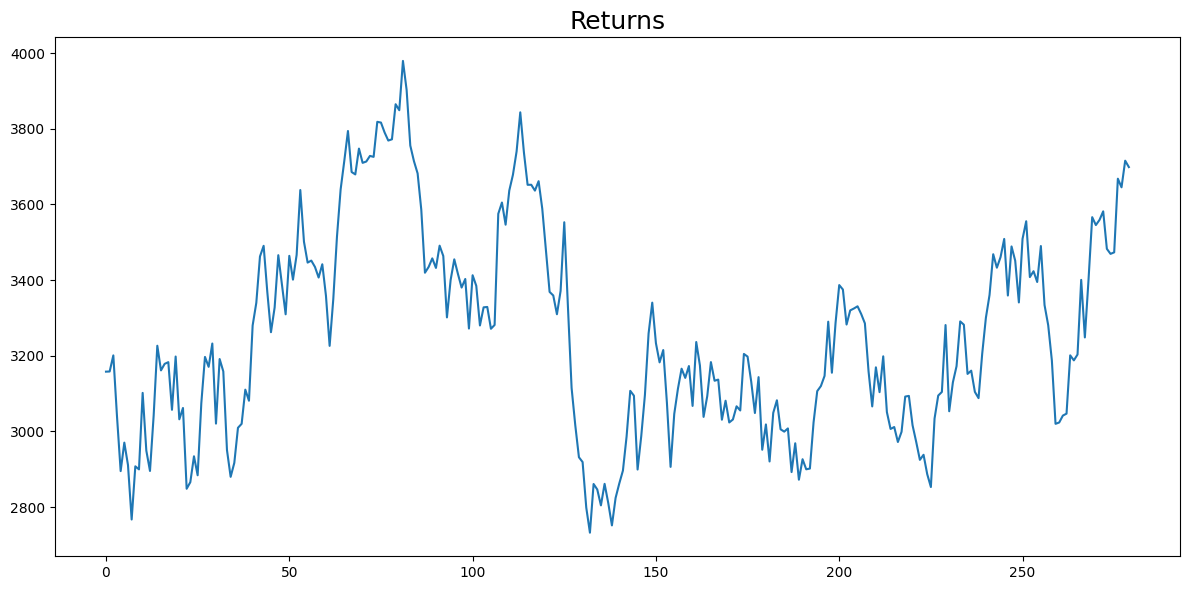

In [22]:
stats = random()
plot_stats(stats)

## Faire évoluer l'environnement